# Approximating likelihood ratios with calibrated classifiers

Gilles Louppe, January 2016.


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [ ]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75, random_state=0),   # c0
    Normal(mu=0.0, sigma=2.0, random_state=1),     # c1
    Normal(mu=1.0, sigma=0.5, random_state=3)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g], random_state=10)
p1 = Mixture(components=components[:2], weights=[0.5, 0.5], random_state=11)

Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

In [3]:
X_true = p0.rvs(5000)

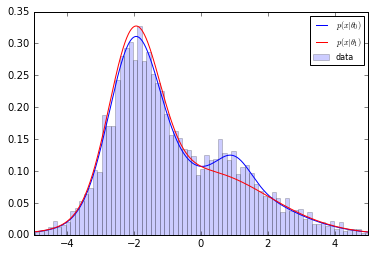

In [4]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.savefig("fig1.pdf")
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios.

In [5]:
from sklearn.model_selection import GridSearchCV
from carl.ratios import CalibratedClassifierRatio
from carl.ratios.cc import as_classifier

# Classifier
from sklearn.linear_model import ElasticNetCV
clf = ElasticNetCV()

# from sklearn.neural_network import MLPRegressor
# clf = as_classifier(MLPRegressor(activation="tanh", hidden_layer_sizes=(30, 30), random_state=0))

# from sklearn.ensemble import ExtraTreesRegressor
# clf = as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15))

# Calibration scheme
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.75, random_state=0)  # 25% for training, 75% for calibration

# No calibration
cc_none = CalibratedClassifierRatio(base_estimator=clf, cv=cv, calibration=None)
cc_none.fit(numerator=p0, denominator=p1, n_samples=100000)

# Calibration + Direct approximation 
cc_direct = CalibratedClassifierRatio(base_estimator=clf, cv=cv)
cc_direct.fit(numerator=p0, denominator=p1, n_samples=100000)

# Calibration + Decomposition of the mixture
from carl.ratios import DecomposedRatio
cc_decomposed = DecomposedRatio(CalibratedClassifierRatio(base_estimator=clf, cv=cv))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=100000)

DecomposedRatio(base_ratio=CalibratedClassifierRatio(base_estimator=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0),
             calibration='histogram',
             cv=StratifiedShuffleSplit(n_iter=1, random_state=0, test_size=0.75,
            train_size=None)))

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:
- `base_estimator` specifying the classifier to be used,
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.

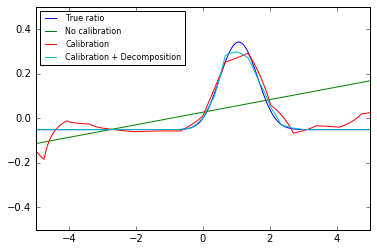

In [6]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
plt.savefig("fig2-mlp.pdf")
plt.show()

Note: For `CalibratedClassifierRatio` objects, the `calibrators_` attribute stores a list of pairs of calibrators (one pair per CV fold). Calibrators implement the `carl.distributions.DistributionMixin` interface and can be used as distributions. For `DecomposedRatio` objects, the `ratios_` attribute stores a dictionary of pairwise ratios modelled from the mixture components. Together, these attributes can be used for inspection, as illustrated below:

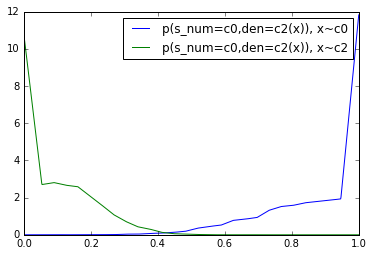

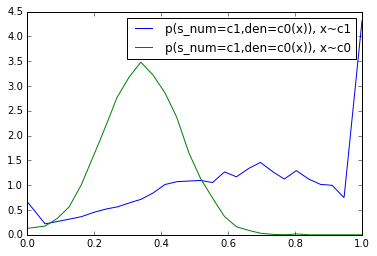

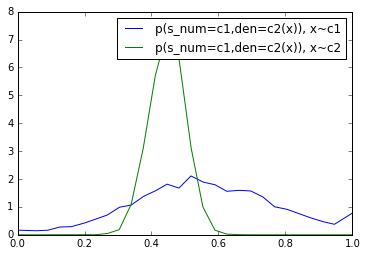

In [7]:
reals = np.linspace(0, 1, num=1000)

for (j, i), r in sorted(cc_decomposed.ratios_.items()):
    if i != j and isinstance(r, CalibratedClassifierRatio):
        cal_num, cal_den = r.calibrators_[0]
        plt.plot(reals, cal_num.pdf(reals.reshape(-1, 1)), 
                 label="p(s_num=c%d,den=c%d(x)), x~c%d" % (j, i, j))
        plt.plot(reals, cal_den.pdf(reals.reshape(-1, 1)), 
                 label="p(s_num=c%d,den=c%d(x)), x~c%d" % (j, i, i))
        plt.legend()
        plt.show()

## Using density ratios for maximum likelihood fit

In the likelihood-free setting, density ratios can be used to find the maximum likelihood estimator $\theta^* = \arg \max_{\theta} p(D | \theta)$ by noticing that $\theta^*$ also maximizes $\prod_{x \in D} \frac{p(x|\theta)}{p(x|\theta_1)}$ for some fixed value of $\theta_1$.

As an example, this can be used to find the bump coefficient in $p_1$, as illustrated below:

In [8]:
# from sklearn.linear_model import ElasticNetCV
# cc = DecomposedRatio(CalibratedClassifierRatio(base_estimator=ElasticNetCV(), cv=cv))
# cc.fit(numerator=p0, denominator=p1, n_samples=50000)

cc = cc_decomposed

def objective(theta):       
    g.set_value(theta[0])  # this indirectly updates weights in p1, 
                           # along with the density ratios computed by cc 
                           # (without having to retrain the classifiers since 
                           # g only affects the weights!)
        
    return -np.mean(cc.predict(X_true, log=True))

from scipy.optimize import minimize
results = minimize(objective, x0=[0.1], 
                   constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

print("Bump coefficient =", bump_coefficient)
print("Found minimum =", results.x[0])

Bump coefficient = 0.05
Found minimum = 0.046096427726


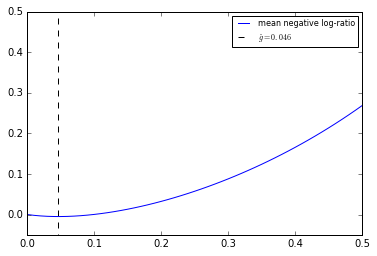

In [9]:
thetas = np.linspace(0., 0.5, num=51)
obj = [objective([theta]) for theta in thetas]

plt.plot(thetas, obj, label="mean negative log-ratio")
plt.vlines(results.x, -5, 5, linestyles="dashed", label=r"$\hat g = %.3f$" % results.x[0])
plt.ylim(-0.05, 0.5)
plt.legend(prop={'size': 8})
plt.savefig("fig3.pdf")
plt.show()